In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
%matplotlib inline

In [2]:
# My function imports
sys.path.insert(0, '../models/')
import data_functions as data_functions
import plot_functions as plot_functions
import train_functions as train_functions

In [3]:
# Other bits
sns.set_style('whitegrid')
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)

In [4]:
# Data
d_train = pd.read_csv('../data/processed/d_train')
d_test = pd.read_csv('../data/processed/d_test')
d_validate = pd.read_csv('../data/processed/d_validate')
d_train = d_train.set_index(['conversation', 'segment'])
d_test = d_test.set_index(['conversation', 'segment'])
d_validate = d_validate.set_index(['conversation', 'segment'])

# First segment is someone introducing the clip so remove
d_train = d_train.query('segment != 1')
dataframes = {'train': d_train, 'test': d_test, 'validate': d_validate}

In [5]:
# # Radu data
# radu_dataframes = {'train': [], 'test': [], 'validate': []}

# for name, dataframe in dataframes.items():
    
#     radu_dataframes[name] = dataframe.copy()
#     radu_dataframes[name]['g/d'] = None
#     radu_dataframes[name]['segment_ratio'] = None
#     radu_dataframes[name]['gap_change'] = None
#     conversations = dataframe.index.get_level_values(0).unique()

#     for conversation in conversations:
#         # Get conversation and shifted conversation dataframes
#         conversation_df = dataframe.loc[conversation]
#         conversation_df_shift = conversation_df.shift(1)

#         # Create useful features
#         gap_duration = conversation_df_shift['gap'] / conversation_df['duration']
#         segment_ratio = conversation_df_shift['duration'] / conversation_df['duration']
#         gap_change = conversation_df_shift['gap'] - conversation_df['gap']

#         # Update
#         radu_dataframes[name].loc[conversation, 'g/d'].update(gap_duration)
#         radu_dataframes[name].loc[conversation, 'segment_ratio'].update(segment_ratio)
#         radu_dataframes[name].loc[conversation, 'gap_change'].update(gap_change)

#     radu_dataframes[name].dropna(inplace=True)
#     radu_dataframes[name] = radu_dataframes[name][['n_words', 'duration', 'gap', 'type']]

In [6]:
#radu_dataframes['validate'].head()

## Data editing to use Radus features

# Basic prediction model

## Machine learning

We first make the features amenable to machine learning. To do this we take the mean of the three features which are:
- Number of words per segment of speech
- Duration of that segment of speech
- Gap between that person talking

In [7]:
mean_df = data_functions.generate_mean_dfs(dataframes)
validate_df = mean_df.pop('validate')

In [8]:
X, y, X_train, y_train, X_test, y_test = data_functions.generate_test_training(mean_df)
X_full = X

In [9]:
X_validate = validate_df.drop(['type'], axis=1)
y_validate = list(map(int, validate_df['type'].values))

#### Feature correlation matrix

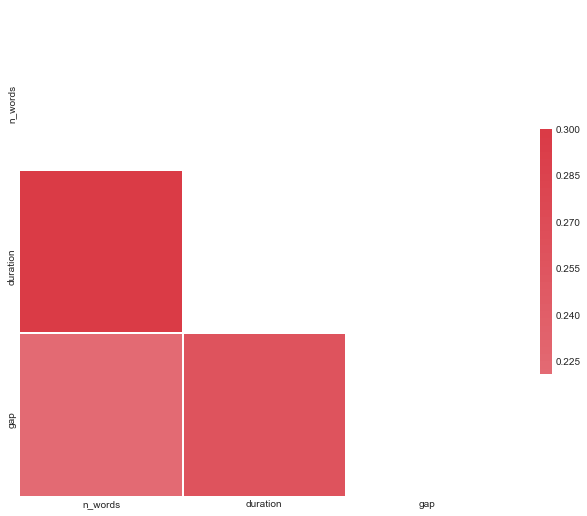

In [10]:
corr = X_full.corr()

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, cmap=cmap, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

#### Normalise features

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X, X_test, X_validate = scaler.transform(X), scaler.transform(X_test), scaler.transform(X_validate)

Get the full sets, training and test sets for this new form of the data. Then train the classifiers.

In [ ]:
classifiers = train_functions.train_classifiers(X_train, y_train, X_test, y_test)

Training accuracies 
----------
Logistic Regression Training accuracy: 94.00%
KNN Training accuracy: 89.95%
SVM Training accuracy: 92.03%
Decision Tree Training accuracy: 87.99%
Random Forest Training accuracy: 90.07%
ADA Boost Training accuracy: 86.03%
GBC Training accuracy: 89.95%

------------------------------------------------------------

Test accuracies 
----------
Logistic Regression test accuracy: 81.76%
KNN test accuracy: 85.46%
SVM test accuracy: 82.13%
Decision Tree test accuracy: 75.46%
Random Forest test accuracy: 85.46%
ADA Boost test accuracy: 75.46%
GBC test accuracy: 75.46%


### Gridsearch

In [ ]:
gs_classifiers = train_functions.perform_gridsearch(classifiers, X_train, y_train)

Logistic Regression best parameters {'C': 0.1, 'penalty': 'l2'}:
KNN best parameters {'algorithm': 'auto', 'n_neighbors': 3}:
SVM best parameters {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}:
Decision Tree best parameters {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1}:


In [ ]:
train_functions.calculate_cv(gs_classifiers, X_train, y_train)

In [ ]:
train_functions.calculate_cv(gs_classifiers, X_test, y_test)

#### Plot learning curve

Logistic regression appears to be the best. Here we plot the learning curve.

In [ ]:
plot_functions.learning(gs_classifiers, X, y)
#plt.savefig('../reports/learning_curves', dpi=300)

#### ROC curve

In [ ]:
plot_functions.roc_ollie(gs_classifiers, X, y)

## Validation

In [ ]:
print('Validation set accuracy \n' + '*'*30 + '\n')

for name, clf in gs_classifiers.items():
    score = clf.score(X_validate, y_validate)
    print('{}: {:.1f}%'.format(name, score*100))

In [ ]:
plot_functions.roc_ollie(gs_classifiers, X_validate, y_validate)
plt.savefig('../reports/ROC', dpi=300)

### Feature importances

In [ ]:
features = {'Normal': ['Number of words', 'Duration', 'Gap'],
            'Radu': ['Number of words', 'g/d', 'Segment Ratio', 'Gap Change']}

# Check feature sizes 
forest = gs_classifiers['Random Forest']
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("{}: {:.3f}".format(features['Normal'][f], importances[indices[f]]))

<br>
<br>
# Are our values correct?

In [ ]:
cbt_session = pd.read_pickle('../data/processed/real/cbt_session')
child_interview = pd.read_pickle('../data/processed/real/child_interview')
real_mean_dfs = {'CBT Session': cbt_session,
            'Child interview': child_interview}

for name, df in real_mean_dfs.items():
    real_mean_dfs[name] = pd.DataFrame(data=df.describe().loc['mean']).T

In [ ]:
for data_name, df in real_mean_dfs.items():
    
    print('For {} \n'.format(data_name) + '*'*30)

    for clf_name, clf in classifiers.items():
        prediction = ('GOOD' if clf.predict(df) == 1 else 'BAD')
        print('{} predicts: {}.'.format(clf_name, prediction))
        
    print('\n')
    

<br>
<br>
# Time dependence

This is todo. The idea here is to use the model derived from above then at each timestep find the probability score for that segment, this give us a p and a 1-p that we can apply Bayes with. We then repeat for the next timestep which will give us a running odds score and an indication as to how the converation is going.

In [ ]:
# For d_train conversation = 1
# Change good bad to binary 
for name, df in dataframes.items():
    df['type'][df['type'] == 'good'] = 1
    df['type'][df['type'] == 'bad'] = 0
    
conversation = d_train.loc[1].drop(['type'], axis=1)

for segment in conversation.reset_index()['segment'].unique():
    segment = conversation.loc[segment]
    pred = gs_classifiers['Random Forest'].predict_proba([segment])
